In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)

# /home/coenraadmiddel/miniconda3/envs/venvRossmann
import os
import wget
from pathlib import Path

%autoreload 2



/home/coenraadmiddel/miniconda3/envs/venvRossmann/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
UsageError: Line magic function `%autoreload` not found.


In [2]:
path = '/home/coenraadmiddel/Documents/RossmannStoreSales/Input/'
trainset_name = 'rossman-store-sales'
path_train = path+'train.csv'
path_test = path+'test.csv'
path_store = path+'store.csv'

In [3]:
store = pd.read_csv(path_store)
store.fillna(0, inplace=True)

In [4]:
train = pd.read_csv(path_train, parse_dates=[2])
test = pd.read_csv(path_test, parse_dates=[2])
# test.fillna(value = 1, inplace = True)

/tmp/ipykernel_10362/614466905.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(path_train, parse_dates=[2])


In [5]:
# merge data with store 
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

# split the last 6 weeks data as hold-out set (idea from Gert https://www.kaggle.com/c/rossmann-store-sales/discussion/18024)
train = train.sort_values(['Date'],ascending = False)
train_total = train.copy()

split_index = 6*7*1115
valid = train[:split_index] 
train = train[split_index:]

# only use train of Sales>0 and Open is 1
valid = valid[(valid.Open != 0)&(valid.Sales >0)]
train = train[(train.Open != 0)&(train.Sales >0)]
train_total = train_total[(train_total.Open != 0)&(train_total.Sales >0)]

In [6]:
np.log1p(train['Sales']).mean()

8.757394063459298

In [7]:
print(train.shape)
# print(valid.shape)

(804056, 18)


/tmp/ipykernel_10362/393461293.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
/tmp/ipykernel_10362/393461293.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g2 = sns.distplot(np.log1p(train['Sales']),his

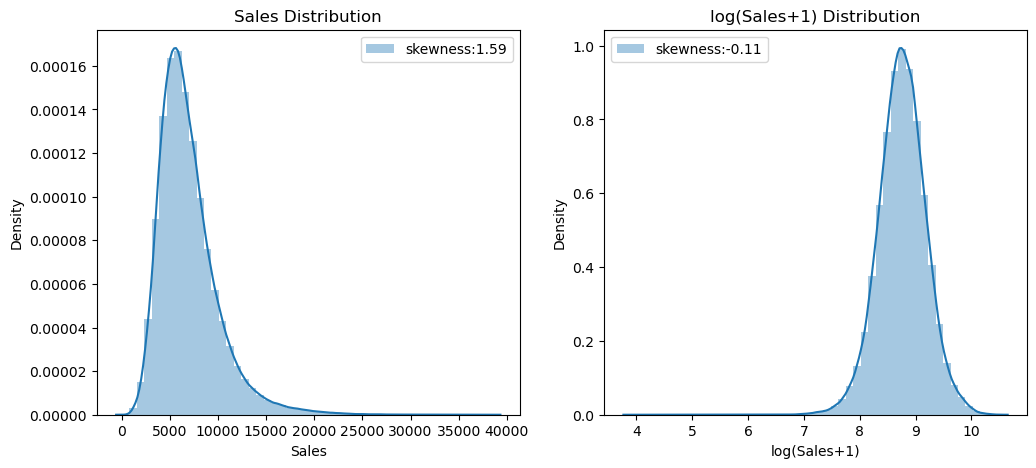

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# check distribution of sales in train set
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
g1 = sns.distplot(train['Sales'],hist = True,label='skewness:{:.2f}'.format(train['Sales'].skew()),ax = ax1)
g1.legend()
g1.set(xlabel = 'Sales', 

ylabel = 'Density', title = 'Sales Distribution')
g2 = sns.distplot(np.log1p(train['Sales']),hist = True,label='skewness:{:.2f}'.format(np.log1p(train['Sales']).skew()),ax=ax2)
g2.legend()
g2.set(xlabel = 'log(Sales+1)',ylabel = 'Density', title = 'log(Sales+1) Distribution')
plt.show()

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804056 entries, 284584 to 238339
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      804056 non-null  int64         
 1   DayOfWeek                  804056 non-null  int64         
 2   Date                       804056 non-null  datetime64[ns]
 3   Sales                      804056 non-null  int64         
 4   Customers                  804056 non-null  int64         
 5   Open                       804056 non-null  int64         
 6   Promo                      804056 non-null  int64         
 7   StateHoliday               804056 non-null  object        
 8   SchoolHoliday              804056 non-null  int64         
 9   StoreType                  804056 non-null  object        
 10  Assortment                 804056 non-null  object        
 11  CompetitionDistance        804056 non-null  flo

In [10]:
train.head().T

,284584,417104,875290,119580,807974
Store,314,458,961,132,887
DayOfWeek,5,5,5,5,5
Date,2015-06-19 00:00:00,2015-06-19 00:00:00,2015-06-19 00:00:00,2015-06-19 00:00:00,2015-06-19 00:00:00
Sales,5032,7362,7764,7964,7776
Customers,562,688,768,692,632
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0
StoreType,a,c,d,d,d


In [11]:
train["StateHoliday"].value_counts()

0    691026
0    112120
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [12]:


def process(data, isTest = False):
    # label encode some features - this does not work. fixing it below
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    # train.StoreType.replace(mappings, inplace=True)
    # train.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
        
    # extract some features from date column  
    data['Month'] = data.Date.dt.month
    data['Year'] = data.Date.dt.year
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    # calculate competiter open time in months
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)
    
    # calculate promo2 open time in months
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data['PromoOpen'].apply(lambda x: x if x > 0 else 0)
                                                 
    # Indicate whether the month is in promo interval
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['month_str'] = data.Month.map(month2str)

    def check(row):
        if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
        else:
            return 0
        
    data['IsPromoMonth'] =  data.apply(lambda row: check(row),axis=1)    
    
    # select the features we need
    features = ['Store'
                , 'DayOfWeek'
                , 'Promo'
                , 'StateHoliday'
                , 'SchoolHoliday'
                , 'StoreType'
                , 'Assortment'
                , 'CompetitionDistance'
                , 'Promo2SinceWeek'
                , 'Promo2SinceYear'
                , 'Year'
                , 'Month'
                , 'Day'
                , 'WeekOfYear'
                , 'CompetitionOpen'
                , 'PromoOpen'
                , 'IsPromoMonth']  
    if not isTest:
        features.append('Sales')
      
       
    data = data[features]
    return data

In [13]:
train = process(train)

# sort by index
train.sort_index(inplace = True)
train_total.sort_index(inplace = True)


/tmp/ipykernel_10362/3753163766.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['WeekOfYear'] = data.Date.dt.weekofyear


In [14]:
train.head().T

,42,43,44,45,46
Store,1,1,1,1,1
DayOfWeek,5,4,3,2,1
Promo,1,1,1,1,1
StateHoliday,0,0,0,0,0
SchoolHoliday,0,0,0,0,0
StoreType,c,c,c,c,c
Assortment,a,a,a,a,a
CompetitionDistance,1270.0,1270.0,1270.0,1270.0,1270.0
Promo2SinceWeek,0.0,0.0,0.0,0.0,0.0
Promo2SinceYear,0.0,0.0,0.0,0.0,0.0


In [15]:
train.columns

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear',
       'CompetitionOpen', 'PromoOpen', 'IsPromoMonth', 'Sales'],
      dtype='object')

In [16]:
    
categorical_columns = ['Store',
                        'DayOfWeek',
                        'Promo',
                        'StateHoliday',
                        'SchoolHoliday',
                        'StoreType',
                        'Assortment',
                        # 'Year',
                        # 'Month',
                        # 'Day',
                        # 'WeekOfYear',
                        'IsPromoMonth']
categorical_dims =  {}

for col in categorical_columns:
    print(col, train[col].nunique())
    train[col] = train[col].astype(str)
    l_enc = LabelEncoder()
    # train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    # categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
    
    
print(categorical_dims)

Store 1115
DayOfWeek 7
Promo 2
StateHoliday 4
SchoolHoliday 2
StoreType 4
Assortment 3
IsPromoMonth 2
{'Store': 1115, 'DayOfWeek': 7, 'Promo': 2, 'StateHoliday': 4, 'SchoolHoliday': 2, 'StoreType': 4, 'Assortment': 3, 'IsPromoMonth': 2}


In [17]:
train.head().T.reset_index()

,index,42,43,44,45,46
0,Store,0.00,0.00,0.00,0.00,0.00
1,DayOfWeek,4.00,3.00,2.00,1.00,0.00
2,Promo,1.00,1.00,1.00,1.00,1.00
3,StateHoliday,0.00,0.00,0.00,0.00,0.00
4,SchoolHoliday,0.00,0.00,0.00,0.00,0.00
5,StoreType,2.00,2.00,2.00,2.00,2.00
6,Assortment,0.00,0.00,0.00,0.00,0.00
7,CompetitionDistance,1270.00,1270.00,1270.00,1270.00,1270.00
8,Promo2SinceWeek,0.00,0.00,0.00,0.00,0.00
9,Promo2SinceYear,0.00,0.00,0.00,0.00,0.00


In [18]:
# split x and y
X_all, y_all = train.drop(columns = ['Sales']), np.log1p(train[['Sales']])

In [19]:
train.describe()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth,Sales
count,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000,804056.000000
mean,557.669482,2.520532,0.447946,0.001489,0.186730,1.204881,0.936812,5445.036515,11.573756,1001.963511,2013.773427,5.800503,15.710591,23.412412,7731.256875,12145.351147,0.168130,6954.822954
std,321.741245,1.723856,0.497283,0.048754,0.389694,1.363172,0.993111,7806.454956,15.297096,1005.870346,0.750094,3.398509,8.652126,14.701627,11229.608674,12072.843590,0.373982,3106.252581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,46.000000
25%,280.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,700.000000,0.000000,0.000000,2013.000000,3.000000,8.000000,11.000000,28.000000,24.500000,0.000000,4856.000000
50%,557.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2320.000000,0.000000,0.000000,2014.000000,5.000000,16.000000,21.000000,90.000000,24156.250000,0.000000,6368.000000
75%,837.000000,4.000000,1.000000,0.000000,0.000000,3.000000,2.000000,6880.000000,22.000000,2012.000000,2014.000000,9.000000,23.000000,36.000000,24163.000000,24171.000000,0.000000,8360.000000
max,1114.000000,6.000000,1.000000,3.000000,1.000000,3.000000,2.000000,75860.000000,50.000000,2015.000000,2015.000000,12.000000,31.000000,52.000000,24186.000000,24186.250000,1.000000,38722.000000


In [20]:
train.head().append(train.sample(5)).append(train.tail()).T.reset_index()

/tmp/ipykernel_10362/4293390566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.head().append(train.sample(5)).append(train.tail()).T.reset_index()
/tmp/ipykernel_10362/4293390566.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train.head().append(train.sample(5)).append(train.tail()).T.reset_index()


,index,42,43,44,45,46,765182,292121,592877,196014,1015755,1017202,1017204,1017205,1017206,1017207
0,Store,0.00,0.00,0.00,0.00,0.00,939.00,364.0,729.00,247.00,129.0,130.0,130.00,130.00,130.00,130.00
1,DayOfWeek,4.00,3.00,2.00,1.00,0.00,4.00,1.0,1.00,0.00,1.0,0.0,5.00,4.00,3.00,2.00
2,Promo,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,0.0,1.0,0.00,0.00,0.00,0.00
3,StateHoliday,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
4,SchoolHoliday,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,1.0,1.00,1.00,1.00,1.00
5,StoreType,2.00,2.00,2.00,2.00,2.00,0.00,0.0,0.00,2.00,0.0,3.0,3.00,3.00,3.00,3.00
6,Assortment,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.0,2.0,2.00,2.00,2.00,2.00
7,CompetitionDistance,1270.00,1270.00,1270.00,1270.00,1270.00,1070.00,17500.0,200.00,3150.00,870.0,5350.0,5350.00,5350.00,5350.00,5350.00
8,Promo2SinceWeek,0.00,0.00,0.00,0.00,0.00,0.00,37.0,0.00,0.00,0.0,22.0,22.00,22.00,22.00,22.00
9,Promo2SinceYear,0.00,0.00,0.00,0.00,0.00,0.00,2009.0,0.00,0.00,0.0,2012.0,2012.00,2012.00,2012.00,2012.00


In [21]:
X_all_cats = X_all[categorical_columns]

In [22]:
# make a list of the number of unique values in each categorical column

catmaxlist = [X_all_cats[col].nunique() for col in X_all_cats.columns]

In [23]:
catmaxlist

[1115, 7, 2, 4, 2, 4, 3, 2]

In [24]:
import random
random.seed(42)
target = 'Sales'
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 
print('Feartures to be used', features)

cat_dims = [X_all_cats[x].nunique() for x in X_all_cats.columns]
print(cat_dims)

# define your embedding sizes : here just a random choice
cat_emb_dim =  [random.randint(2, min(x, 10)) for x in catmaxlist]
print(cat_emb_dim)
print("Categorical Dimensions: ", len(cat_dims))
print("Categorical Embedding Dimensions: ", len(cat_emb_dim))
assert len(cat_dims) == len(cat_emb_dim)

print("Number of categorical features and embedding dimensions must be equal")


Feartures to be used ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']
[1115, 7, 2, 4, 2, 4, 3, 2]
[3, 2, 2, 2, 2, 2, 2, 2]
Categorical Dimensions:  8
Categorical Embedding Dimensions:  8
Number of categorical features and embedding dimensions must be equal


In [25]:
if "Set" not in train.columns:
    train.reset_index(inplace=True, drop=True)
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [26]:
train_indices.shape

(643484,)

In [27]:
X_all.values[train_indices].shape

(643484, 17)

In [28]:
X_train = X_all.values[train_indices]
y_train = y_all.values[train_indices].reshape(-1, 1)

X_valid = X_all.values[valid_indices]
y_valid = y_all.values[valid_indices].reshape(-1, 1)

X_test = X_all.values[test_indices]
y_test = y_all.values[test_indices].reshape(-1, 1)

In [29]:
train.head().T.reset_index()

,index,0,1,2,3,4
0,Store,0,0,0,0,0
1,DayOfWeek,4,3,2,1,0
2,Promo,1,1,1,1,1
3,StateHoliday,0,0,0,0,0
4,SchoolHoliday,0,0,0,0,0
5,StoreType,2,2,2,2,2
6,Assortment,0,0,0,0,0
7,CompetitionDistance,1270.0,1270.0,1270.0,1270.0,1270.0
8,Promo2SinceWeek,0.0,0.0,0.0,0.0,0.0
9,Promo2SinceYear,0.0,0.0,0.0,0.0,0.0


In [30]:
#get categorical feature indexes 

cat_idxs = [X_all.columns.get_loc(c) for c in categorical_columns if c in X_all]


In [31]:
print('Building model...')
print('Number of features: {}'.format(X_train.shape[1]))
print('Number of training samples: {}'.format(X_train.shape[0]))
print('Number of categorical features: {}'.format(len(cat_dims)))
print('Cat_dims: {}'.format(cat_dims))
print('Indexes of categorical features: {}'.format(cat_idxs))
print('List of categorical features and their embedding dimensions: {}'.format(list(zip(X_all_cats.columns, cat_emb_dim))))



Building model...
Number of features: 17
Number of training samples: 643484
Number of categorical features: 8
Cat_dims: [1115, 7, 2, 4, 2, 4, 3, 2]
Indexes of categorical features: [0, 1, 2, 3, 4, 5, 6, 16]
List of categorical features and their embedding dimensions: [('Store', 3), ('DayOfWeek', 2), ('Promo', 2), ('StateHoliday', 2), ('SchoolHoliday', 2), ('StoreType', 2), ('Assortment', 2), ('IsPromoMonth', 2)]


wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-keyring_1.0-1_all.deb

sudo dpkg -i cuda-keyring_1.0-1_all.deb


In [33]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Using {}".format(DEVICE))

clf = TabNetRegressor(cat_dims=cat_dims
                      , cat_emb_dim=cat_emb_dim
                      , cat_idxs=cat_idxs
                      , device_name = DEVICE
)

Using cpu


/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/pytorch_tabnet/abstract_model.py:80: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [34]:
max_epochs = 100 if not os.getenv("CI", False) else 2
print(max_epochs)

100


In [35]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(643484, 17)
(643484, 1)
(79984, 17)
(79984, 1)


In [36]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    # num_workers=0,
    # drop_last=False,
    # augmentations=aug, #aug
) 

epoch 0  | loss: 0.92849 | train_rmsle: 0.00153 | train_mae: 0.29439 | train_rmse: 0.37853 | train_mse: 0.14328 | valid_rmsle: 0.00152 | valid_mae: 0.29385 | valid_rmse: 0.37791 | valid_mse: 0.14282 |  0:37:48s
epoch 1  | loss: 0.07888 | train_rmsle: 0.00043 | train_mae: 0.14888 | train_rmse: 0.20007 | train_mse: 0.04003 | valid_rmsle: 0.00043 | valid_mae: 0.14921 | valid_rmse: 0.20063 | valid_mse: 0.04025 |  1:15:29s
epoch 2  | loss: 0.04175 | train_rmsle: 0.00035 | train_mae: 0.13426 | train_rmse: 0.18152 | train_mse: 0.03295 | valid_rmsle: 0.00035 | valid_mae: 0.13487 | valid_rmse: 0.18233 | valid_mse: 0.03325 |  1:52:46s
epoch 3  | loss: 0.03601 | train_rmsle: 0.00031 | train_mae: 0.12528 | train_rmse: 0.17027 | train_mse: 0.02899 | valid_rmsle: 0.00031 | valid_mae: 0.1261  | valid_rmse: 0.17097 | valid_mse: 0.02923 |  2:31:18s
epoch 4  | loss: 0.03331 | train_rmsle: 0.0003  | train_mae: 0.12617 | train_rmse: 0.16721 | train_mse: 0.02796 | valid_rmsle: 0.0003  | valid_mae: 0.12691 

/home/coenraadmiddel/Documents/RossmannStoreSales/TabNet/tabnet/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Save model and load

In [37]:
# save tabnet model
saving_path_name = "./tabnet_model_test_second_try"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_second_try.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

In [43]:
# if loaded_cl
#     loaded_preds = loaded_clf.predict(X_test)
#     loaded_test_mse = mean_squared_error(loaded_preds, y_test)
# else:
loaded_preds = clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {trainset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR rossman-store-sales : 0.014900591809687539


# Global explainability : feat importance summing to 1

In [44]:
clf.feature_importances_

array([1.35933555e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.23526974e-01,
       0.00000000e+00, 2.01626530e-01, 0.00000000e+00, 4.37027460e-01,
       0.00000000e+00, 4.53391828e-06, 0.00000000e+00, 2.45496505e-02,
       7.73312961e-02])

# Local explainability and masks

In [46]:
explain_matrix, masks = clf.explain(X_test)

In [59]:
X_test.shape

(80588, 17)

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

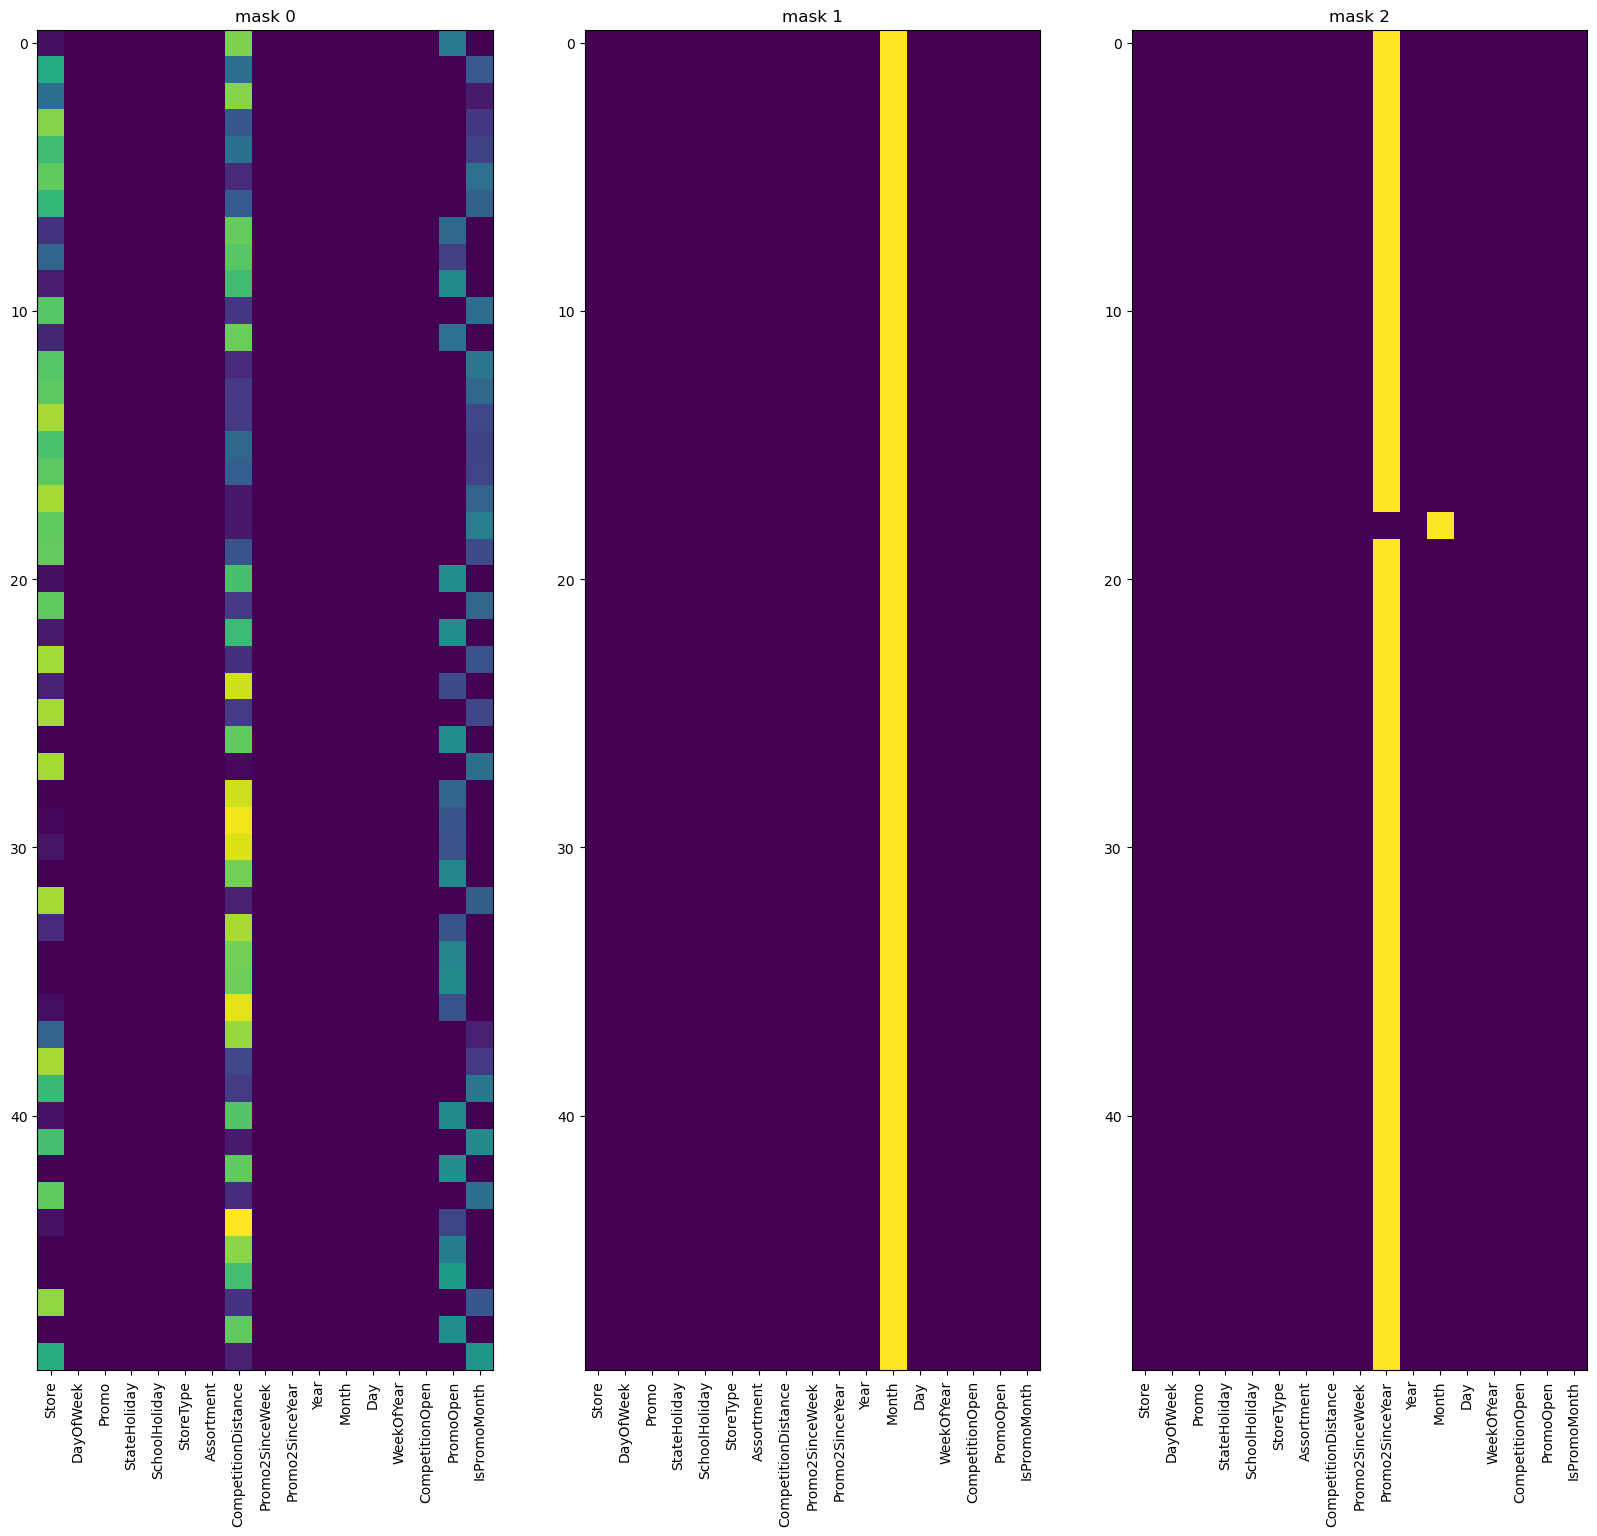

In [62]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticks([x for x in range(len(X_all.columns))])
    axs[i].set_xticklabels([x for x in X_all.columns], rotation=90)


In [60]:
len([x for x in X_all.columns])

17

# XGB

In [63]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

/home/coenraadmiddel/miniconda3/envs/venvRossmann/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:7.44459
[10]	validation_0-rmse:2.61582
[20]	validation_0-rmse:0.95808
[30]	validation_0-rmse:0.42958
[40]	validation_0-rmse:0.28930
[50]	validation_0-rmse:0.25203
[60]	validation_0-rmse:0.23619
[70]	validation_0-rmse:0.22111
[80]	validation_0-rmse:0.20927
[90]	validation_0-rmse:0.19807
[100]	validation_0-rmse:0.18898
[110]	validation_0-rmse:0.18061
[120]	validation_0-rmse:0.17318
[130]	validation_0-rmse:0.16665
[140]	validation_0-rmse:0.16105
[150]	validation_0-rmse:0.15582
[160]	validation_0-rmse:0.15067
[170]	validation_0-rmse:0.14682
[180]	validation_0-rmse:0.14317
[190]	validation_0-rmse:0.14019
[200]	validation_0-rmse:0.13853
[210]	validation_0-rmse:0.13504
[220]	validation_0-rmse:0.13330
[230]	validation_0-rmse:0.13156
[240]	validation_0-rmse:0.12875
[250]	validation_0-rmse:0.12698
[260]	validation_0-rmse:0.12516
[270]	validation_0-rmse:0.12399
[280]	validation_0-rmse:0.12244
[290]	validation_0-rmse:0.12102
[300]	validation_0-rmse:0.11959
[310]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=8, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             nthread=None, num_parallel_tree=None, objective='reg:linear', ...)

In [65]:
preds = np.array(clf_xgb.predict(X_valid))
valid_mse = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_mse)

preds = np.array(clf_xgb.predict(X_test))
test_mse = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_mse)

0.008903043879770721
0.00897729870324486


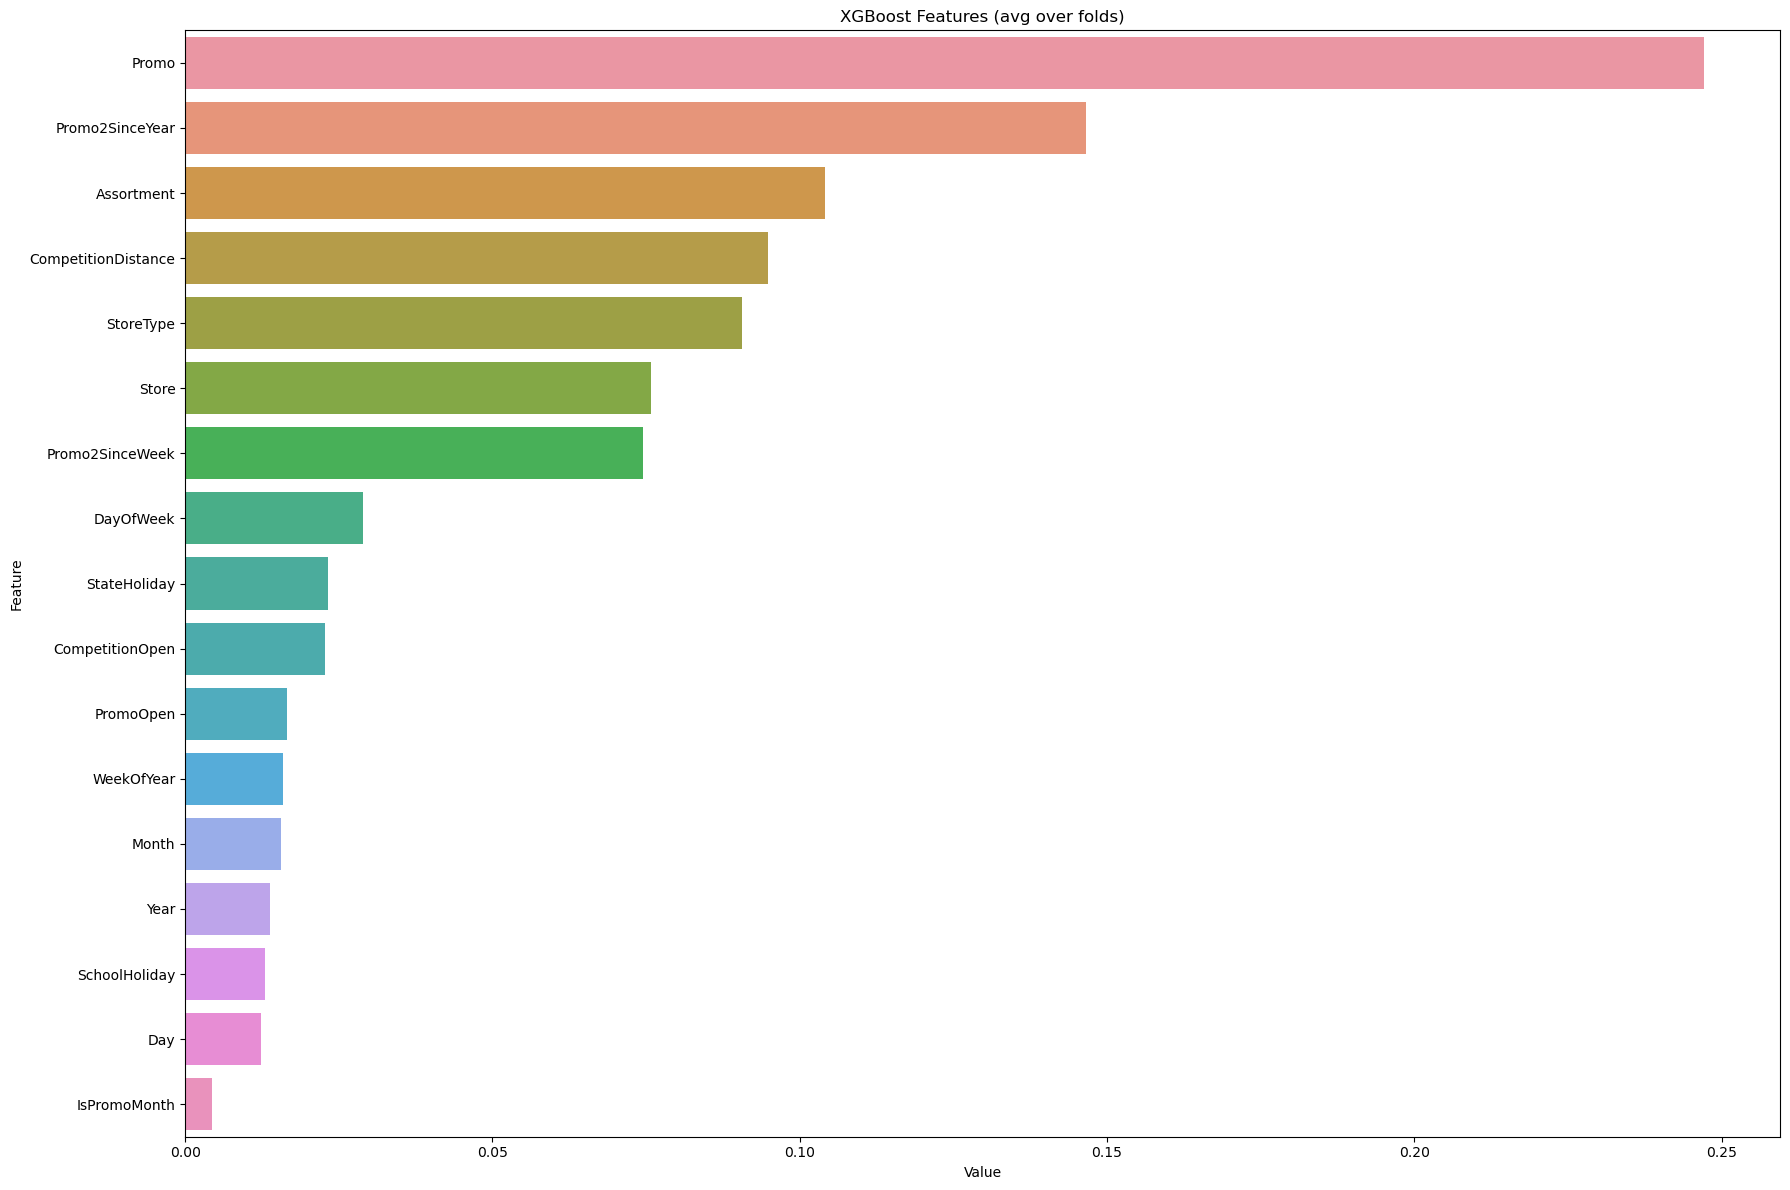

In [73]:
 #make a graph of the feature imporances including their names

feature_imp = pd.DataFrame(sorted(zip(clf_xgb.feature_importances_,X_all.columns)), columns=['Value','Feature'])

plt.figure(figsize=(18, 12))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features')
plt.tight_layout()
plt.show()


In [ ]:
FINAL TEST SCORE FOR rossman-store-sales : 0.014900591809687539


In [66]:
0.014900591809687539/0.00897729870324486

1.6598079558499814